In [1]:
import gymnasium as gym

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from time import sleep

from tqdm.notebook import tqdm
from collections import namedtuple
from collections import deque
import random

## The Pendulum environment

The pendulum environment is a classic reinforcement learning control task. The environment consists of a pendulum that can swing 360 degrees. The pendulum is actuated by applying a torque on the joint between the pendulum and the base. The goal is to swing up the pendulum so it stays upright. The pendulum starts in a random position, and the goal is to get it to the upright position and keep it there.

### Termination and truncations conditions
The episode truncates after 200 time steps. There is no termination condition.

### State space
At each time point, the observations space is a 3-dimensional vector. The first two dimensions are the sin and cos of the angle of the pendulum. The third dimension is the angular velocity of the pendulum.

### Action space
The action space is a single continuous value, which is the torque applied to the joint. The torque is bounded between -2 and 2.

### Rewards
The reward at each time step is given by:
$$ r_t = -\left(\theta^2 + 0.1 \dot{\theta}^2 + 0.001 a^2\right) $$
where $\theta$ is the angle of the pendulum, $\theta_{dot}$ is the angular velocity of the pendulum, and $a$ is the torque applied to the joint. Note that the angle $\theta$ is normalized to be between $-\pi$ and $\pi$, so that the reward is maximised when the pendulum is upright.



# The DDPG algorithm components

The DDPG algorithm uses the following components

## Networks

1. **The policy network**: This is the core of DDPG. The policy network is a deterministic mapping from states to actions. 
2. **The value network**: This is a Q-network much like the one used in DQN. Unlike the DQN network, this network takes in state-action pairs and outputs values estimates for that pair. 
3. **The target policy network**: This is a (delayed) copy of the policy network used for calculating target values for performing regression on the value network.
4. **The target value network**: This is a (delayed) copy of the value network used for:
    * Calculating the target values for performing regression on the value network
    * Forming the objective function on which the policy network is trained.

## Other elements

1. **Replay buffer**: This functions like in the DQN algorithm. This stores the last M transitions from which we sample to perform network updates.
2. **Exploration policy**: In the DQN algorithm, exploration was achieved using an $\epsilon$-greedy policy. In DDPG, exploration is achieved by adding noise to the output of the policy network. 

In [6]:
# We now define the value network 

    # Initialise the network using the dimensions of the state and action spaces
    def __init__(self, env):
        # Use the nn.Module's __init__ method to ensure that the parameters can be updated during training
        super(Q_net, self).__init__()
        # Define the dimensions of the state and action spaces
        state_dim = env.observation_space.shape[0]
        action_dim = env.action_space.shape[0]
        # Define the layers of the network. This network will be a MLP.  
        # The network takes in (state-action) pairs and returns values. 
        # We will use the nn.Sequential() container to store the layers of the MLP.  
        self.Layers = 

    # Define the forward pass of the network
    
        # Reshape the state to be batch_size x state_dim
        state = state.view(state.size(0), -1)
        # Reshape the action to be batch_size x action_dim
        action = action.view(action.size(0), -1)
        # Concatenate the state and action
        x = torch.cat((state, action), dim=1)
        # Pass the concatenated input through the layers of the network
        x = self.Layers(x)
        # Return the output of the network
        return x

In [7]:
# Next, the policy network

    # Initialise the network using the dimensions of the state and action spaces
    def __init__(self, env):
        # Use the nn.Module's __init__ method to ensure that the parameters can be updated during training
        super(policy_network, self).__init__()
        # save the action space limits as torch tensors
        self.action_low = torch.tensor(env.action_space.low, dtype=torch.float32)
        self.action_high = torch.tensor(env.action_space.high, dtype=torch.float32)
        self.state_dim = env.observation_space.shape[0]
        self.action_dim = env.action_space.shape[0]
        # Define the layers of the network. This network will be a MLP.  
        # This takes in states and returns actions.
        # We will use the nn.Sequential() container to store the layers of the MLP.  
        # At the end we pass the output of the network through a tanh activation function.
        self.Layers = 

    # Define the forward pass of the network
    
        # Pass the state through the network
        x = self.Layers(state)
        # Scale the output of the network to be within the action space
        x = x * (self.action_high - self.action_low) / 2 + (self.action_high + self.action_low) / 2        
        return x

In [8]:
# Define the transition named tuple
# This will be used to store the transitions (state, action, reward, next_state, terminated) in the replay buffer
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'terminated'))

# Define the ReplayBuffer class
class ReplayBuffer:
    # Initialise the buffer with a capacity. 
    def __init__(self, capacity):
        # Use a deque object to implement the buffer
        self.buffer = deque(maxlen=capacity)

    # Define the push method to add a transition to the buffer
    def push(self, state, action, reward, next_state, terminated):
        self.buffer.append(Transition(state, action, reward, next_state, terminated))

    # Sample a batch of transitions for training
    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

In [9]:
# Define the Polyak averaging function
def polyak_average(polyak, base_network, target_network):
    # Retrive the state dictionaries of the base and target networks
    base_network_state_dict = 
    target_network_state_dict = 
    # Iterate through the parameter names
    for param_name in base_network_state_dict.keys():
        # Update the target network's parameters using Polyak averaging
        target_network_state_dict[param_name] = 
    # Load the updated state dictionary into the target value network
    

## The DDPG agent
We now define the DDPG agent class. 

1. **The value system**, which consists of:
    - **Value network**, implemented using the Q_net class
    - **A target value network**, implemented using the Q_net class
    - **Value optimiser**, which is used to train the value network
2. **The policy system**, which consists of:
    - **A policy network**, implemented using the Policy_net class
    - **A target policy network**, implemented using the Policy_net class
    - **Policy Optimiser**, which is used to train the value network
3. **A replay buffer**, implemented using the ReplayBuffer class
4. **A noisy policy**, implemented by adding noise to the output of the policy network
5. **Target network update function**, which updates the target networks using Polyak averaging


In [10]:
# Define the DDPG_agent class
class DDPG_agent:
    def __init__(self, env, buffer_capacity=200000, gamma=0.99, sigma=0.1, lr=0.001, batch_size=64, poylak = 0.99):
        # Save the input parameters (state and action dimensions, buffer capacity, discount factor, noise standard deviation, learning rate, batch size, and polyak parameter)
        self.state_dim = env.observation_space.shape[0]
        self.action_dim = env.action_space.shape[0]
        self.action_low = env.action_space.low
        self.action_high = env.action_space.high
        self.buffer_capacity = buffer_capacity
        self.gamma = gamma
        self.sigma = sigma
        self.batch_size = batch_size
        self.polyak = poylak

        # Create the value network
        self.value = 
        # Create the target value network
        self.target_value = 
        # Create the optimiser for the value network
        self.value_optimiser = 
        # Set the target value network's parameters to be the same as the value network's
        
        # Create the policy network
        self.policy = 
        # Create the target policy network
        self.target_policy =
        # Create the optimiser for the policy network with the maximize=True argument to perform gradient ascent
        self.policy_optimiser =
        # Set the target policy network's parameters to be the same as the policy network's
        
        # Create the replay buffer
        self.replay_buffer = ReplayBuffer(buffer_capacity)
    
    # Define the update method for the target networks
    def update_targets(self):
        # Update the target value network

        # Update the target policy network
        

    # Define the noisy policy
    def noisy_policy(self, state):
        # Pass the state through the policy network to get the action
        action = self.policy(state)
        # Add noise to the action
        action += 
        # Clip the action to the range of the action space
        action = torch.clamp(action, torch.tensor(self.action_low), torch.tensor(self.action_high))
        # Return the noisy action
        return action

## Interacting with the environment

During training, the DDPG agent must interact with the environment in order to collect transitions to be added to the replay buffer. We define an **interact** function that takes in the environment, the DDPG agent, and the number of time steps to interact for. This function will use the noisy policy to select actions, and will store the transitions in the replay buffer.

In [ ]:
# Define the interact method
# This method takes in an agent, an environment, and the number of steps to interact for.
def interact(agent, env, n_steps, current_state):
    reward_list = []
    # Loop over the steps
    with torch.no_grad():
        for step in range(n_steps):
            # Choose an action using the epsilon greedy policy
            action = agent.noisy_policy(torch.tensor(current_state, dtype=torch.float32))
            # Take a step in the environment using the action
            next_state, reward, terminated, truncated, info = env.step(action)
            # Append the reward to the reward list
            reward_list.append(reward) 
            # Push the transition to the replay buffer
            agent.replay_buffer.push(current_state, action, reward, next_state, terminated)
            # Update the current state
            current_state = next_state
            # Reset the environment if the episode is terminated or truncated
            if terminated or truncated:
                current_state, info = env.reset()
    # Return the reward list and the updated state
    return reward_list, current_state
    
            

## Training the DDPG agent

We define a **update weights** function that updates the weights of the value and policy networks for a DDPG agent. This function will:
1. Sample a mini-batch of transitions from the replay buffer
2. Extracts the states, actions, rewards, next_states, and terminated flags from the transitions
3. Uses the target network, rewards, and terminated flags to compute the regression targets for the value network 
4. Computes:
    + The MSE loss between the value network predictions and the regression targets
    + The objective function for the policy network
5. Runs backpropagation and updates the weights of the networks

As a reminder, the regression targets for $Q(S,A)$ are given by:
$$ R + \gamma (1-\text{terminated}) Q(S',\mu(S'))$$

In [12]:
# This method updates the weights of the value-network of the agent using a batch of transitions
def update_weights(agent):
    # Sample a batch of transitions from the replay buffer
    batch = agent.replay_buffer.sample(agent.batch_size)
    
    # Extract the batch of states as float32 tensors 
    states = torch.tensor([transition.state for transition in batch], dtype=torch.float32)
    # Extract the batch of actions as int64 tensors
    actions = torch.tensor([transition.action for transition in batch], dtype=torch.float32)
    # Extract the batch of rewards as float32 tensors
    rewards = torch.tensor([transition.reward for transition in batch], dtype=torch.float32)
    rewards = rewards.unsqueeze(1)
    # Extract the batch of next states as float32 tensors
    next_states = torch.tensor([transition.next_state for transition in batch], dtype=torch.float32)
    # Extract the batch of terminated flags as bool tensors
    terminated = torch.tensor([transition.terminated for transition in batch], dtype=torch.bool)

    # First we update the value network
    with torch.no_grad():
        # Compute the actions taken by the policy network for the next states
        next_actions = 
        # Compute the next step values using the target network
        next_step_values = 
        # Zero out the max-next-values for the terminal states
        next_step_values[terminated] = 0
        # Compute the target values
        target_values = 
        
    # Compute the Q values for the state-action pairs
    q_values = 
    # Compute the loss using the mean squared error
    loss = 

    # Zero the gradients using the optimiser
    
    # Compute the gradients of the loss through backpropagation
    
    # Update the weights of the value network using the gradients
    

    # Next we update the policy network 
    values = 
    # Compute the objective function 
    objective = values.mean()
    # Zero the gradients using the optimiser
    
    # Compute the gradients of the objective function through backpropagation
    
    # Update the weights of the policy network using the gradients
    
    

## The training loop for the agent
We now put everything together into a training loop for the DQN agent. This loop will:
1. Interact with the environment for a number of time steps
2. Update the weights of the value network
3. Synchronize the target network with the value network at regular intervals

In [13]:
# Define the train_loop method
def train_loop(agent, env, interactions_per_update, update_steps):
    # Initialise the environment
    current_state, info = env.reset()

    # Gather initial interactions for the experience replay buffer
    reward_list, current_state = interact(agent, env, 10000, current_state)
    
    # Loop over the update_steps
    for step in tqdm(range(update_steps)):
        # Interact with the environment
        new_rewards, current_state = interact(agent, env, interactions_per_update, current_state)
        
        # Append the new rewards to the reward list
        reward_list += new_rewards

        # Update the weights
        update_weights(agent)

        # Update the target networks
        agent.update_targets()
    return reward_list

## Some helper functions
We define some helper functions to:
1. Evaluate the agent's performance
2. Visualise the agent's performance
3. Plot the (smoothed) losses during training

In [14]:
# Define the evaluate function
def evaluate(agent, env, n_episodes):
    # Initialise the list of rewards
    rewards = []
    
    # Loop over the episodes
    for episode in tqdm(range(n_episodes)):
        # Reset the environment
        current_state, info = env.reset()
        # Initialise the episode reward
        episode_reward = 0
        
        # Loop over the steps
        with torch.no_grad():
            while True:
                # Choose the action according to the policy network
                action = agent.policy(torch.tensor(current_state, dtype=torch.float32))
                # Take the action
                next_state, reward, terminated, truncated, info = env.step(action)
                # Update the state and reward
                current_state = next_state
                episode_reward += reward
                # Break if the episode has terminated
                if terminated or truncated:
                    break
        
        # Append the episode reward to the list of rewards
        rewards.append(episode_reward)
    # Return the mean of the rewards
    return np.mean(rewards)

In [15]:
# Define the visualise function
# This displays the agent's behaviour in the environment for 500 steps.  
def visualise(agent, env, n_steps):
    # Reset the environment
    current_state, info = env.reset()

    # Initialise the list of frames   
    frames = []

    with torch.no_grad():
        for _ in range(n_steps):
            # Render the environment and store the frame
            frame = env.render()
            frames.append(frame)

            action = agent.policy(torch.tensor(current_state, dtype=torch.float32)).detach().numpy()
            next_state, reward, terminated, truncated, info = env.step(action)
            current_state = next_state
            if terminated or truncated:
                break

    # Display the movie
    for frame in frames:
        clear_output(wait=True)
        plt.imshow(frame)
        plt.show()
        sleep(0.003)

In [31]:
# Plot a smoothed version of the rewards
def plot_rewards(rewards):
    # Convert the rewards to a numpy array
    rewards = np.array(rewards)
    # Create a smoothed version of the rewards
    smoothed_rewards = np.convolve(rewards, np.ones(1000)/1000, mode='valid') 
    plt.plot(range(len(smoothed_rewards)), smoothed_rewards)
    plt.xlabel('Interaction step')
    plt.ylabel('Average reward')
    plt.xlim(0, len(smoothed_rewards))
    plt.ylim(min(smoothed_rewards), 1.1*max(smoothed_rewards))
    plt.show()

# Let's gooooo

We will now train our network using the DDPG algorithm and visualise the agent's performance. Have fun!

In [27]:
# Create the pendulum environment
env = gym.make('Pendulum-v1', render_mode='rgb_array')
# Reset the environment
env.reset()
# Create the agent
agent = DDPG_agent(env)

In [28]:
# Evaluate the agent's performance before training
print('Performance before training:', evaluate(agent, env, 100))

  0%|          | 0/50 [00:00<?, ?it/s]

Performance before training: -1339.8413


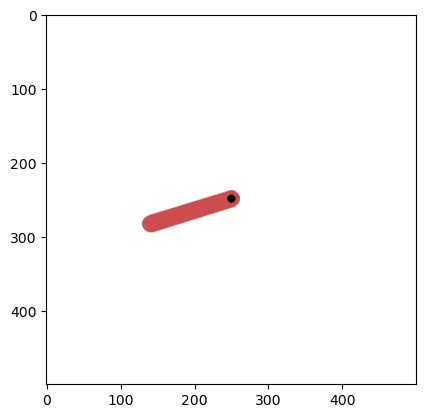

In [20]:
# Visualise the agent's behaviour before training
visualise(agent, env, 200)

In [29]:
# Train the agent, saving the losses
rewards_list = train_loop(agent, env, interactions_per_update=15, update_steps=7500)

  0%|          | 0/6000 [00:00<?, ?it/s]

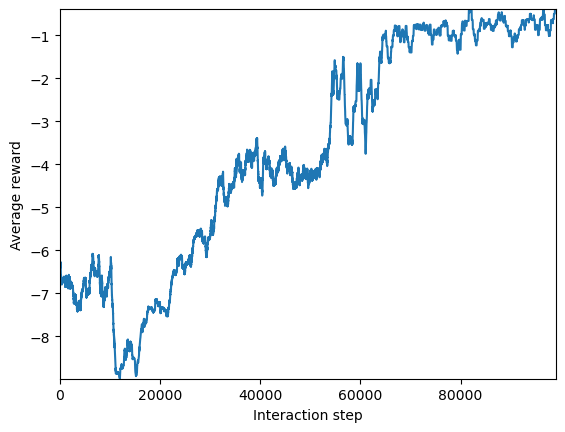

In [32]:
# Plot the rewards
plot_rewards(rewards_list)

In [23]:
# Evaluate the agent's performance after training
print('Performance after training:', evaluate(agent, env, 100))

  0%|          | 0/50 [00:00<?, ?it/s]

Performance after training: -134.50952


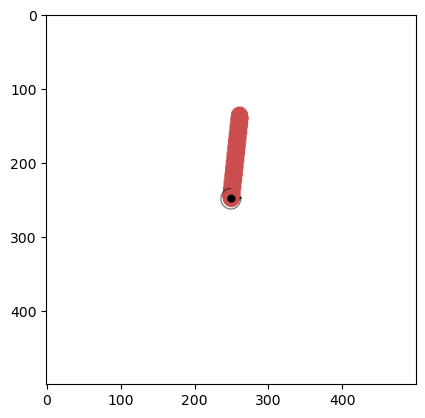

In [33]:
# Visualise the agent's behaviour after training
visualise(agent, env, 200)